# 16. 다음에 볼 영화 예측하기

# 16-6. 프로젝트 - Movielens 영화 SBR

### 라이브러리 버전 확인

In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### Step 1. 데이터의 전처리

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


- Time 항목에 UTC time 가 포함되어, 1970년 1월1일 부터 경과된 시간이 기재됨

이를 datetime으로 바꾸기 위한 작업 진행

[참고링크]

https://stackoverflow.com/questions/41783003/how-do-i-convert-timestamp-to-datetime-date-in-pandas-dataframe

In [5]:
from datetime import datetime

data['Time'] = [datetime.fromtimestamp(x) for x in data['Time']]

In [6]:
data['Time']

31        2000-12-31 22:00:19
22        2000-12-31 22:00:55
27        2000-12-31 22:00:55
37        2000-12-31 22:00:55
24        2000-12-31 22:01:43
                  ...        
1000019   2001-08-10 14:40:29
999988    2001-08-10 14:41:04
1000172   2001-08-10 14:41:04
1000167   2001-08-10 14:41:26
1000042   2001-08-20 13:44:15
Name: Time, Length: 1000209, dtype: datetime64[ns]

In [7]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [8]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### session length

In [9]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [10]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

세션의 길이 평균 96~ 165

In [11]:
session_length.min(), session_length.max()

(20, 2314)

In [12]:
session_length.quantile(0.999)

1343.181000000005

- quantile : 소득구간을 나타내는 개념

파라미터가 0.999는 전체 데이터의 0.999%를 확인 할 수 있다

99.9% 세션은 길이가 1343이하

In [13]:
long_session = session_length[session_length==2314].index[0]

data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [14]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

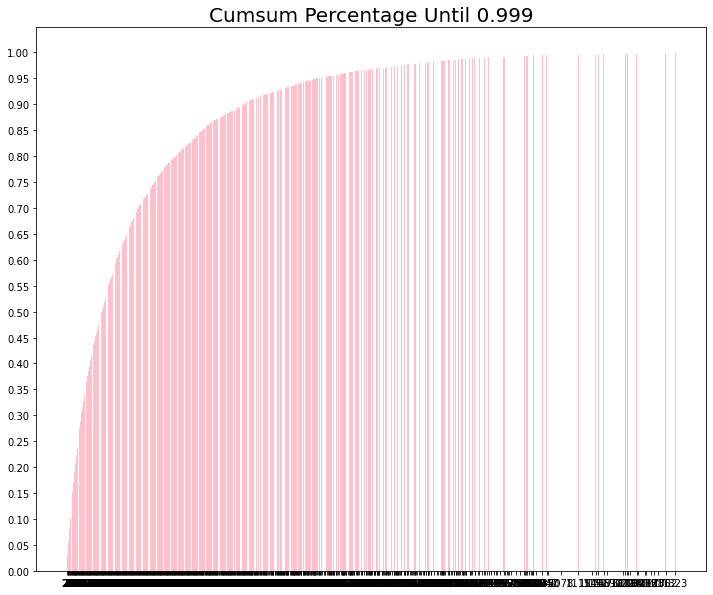

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='pink')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### session time

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 정리


2000년 4월 25일 부터

2003년 2월 28일까지의 데이터

In [17]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [18]:
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

In [19]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


#### data cleansing

In [20]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [21]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [22]:
data.count()

UserId    999611
ItemId    999611
Rating    999611
Time      999611
dtype: int64

#### train / valid / test split

In [23]:
# test_path = data_path / 'ratings.dat'
# test= load_data(test_path)
# test['Time'].min(), test['Time'].max()

In [24]:
# split
# UserId를 기준으로 train, val, test = 0.7, 0.2, 0.1로 분리
tr = data[data['UserId'] <= 4228]
val = data[(data['UserId'] > 4228) & (data['UserId'] <= 5436)]
test = data[data['UserId'] > 5436]

In [25]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [26]:
# tr, test = split_by_date(data, n_days=1)
# tr, val = split_by_date(tr, n_days=1)

In [27]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [28]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 705588
	 Sessions: 4228
	 Items: 3416
	 First Time : 2000-08-03 14:24:25
	 Last Time : 2003-02-28 00:51:39

* valid Set Stats Info
	 Events: 193323
	 Sessions: 1208
	 Items: 3342
	 First Time : 2000-06-03 05:20:31
	 Last Time : 2003-02-28 17:49:50

* test Set Stats Info
	 Events: 100700
	 Sessions: 604
	 Items: 3172
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 13:12:12



In [29]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [30]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

#### session dataset

In [31]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [32]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [33]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 704344, 705565, 705588], dtype=int32)

In [34]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4225, 4226, 4227])

#### session dataloader

In [35]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [36]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [37]:
iter_ex = iter(tr_data_loader)

In [38]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### Step 3. 모델 구성

#### evaluation metric

In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### model architecture

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [42]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [43]:
# args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [44]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (512, 50)                 0         
_________________________________________________________________
dense (Dense)                (512, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

#### model training

In [45]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [46]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')

In [47]:
train_model(model, args)

Evaluation:  54%|█████▍    | 202/375 [07:50<06:43,  2.33s/it]


	 - Recall@20 epoch 1: 0.101137
	 - MRR@20    epoch 1: 0.023500



Evaluation:  54%|█████▍    | 202/375 [10:02<08:36,  2.98s/it] 


	 - Recall@20 epoch 2: 0.185121
	 - MRR@20    epoch 2: 0.047474



Evaluation:  54%|█████▍    | 202/375 [07:11<06:09,  2.13s/it]

	 - Recall@20 epoch 3: 0.250638
	 - MRR@20    epoch 3: 0.065389



train_loss 값이 진행될수록 감소하고

Recall@k와 MRR@k 의 값이 증가하는것을 볼 수 있었다.

epochs을 더 늘려서 진행해보면 어떤 결과를 보여줄지 궁금하다.

### Step 5. 모델 테스트

#### inference

In [48]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 37/195 [01:16<05:24,  2.06s/it]

	 - Recall@20: 0.264780
	 - MRR@20: 0.070996



### 성능 향상 시켜보기

##### 1. drop_rate 변경해보기

In [49]:
args1 = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.4, lr=0.001, epochs=3, k=20)

In [50]:
model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (512, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (512, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [51]:
train_model(model1, args1)

Evaluation:  54%|█████▍    | 202/375 [07:37<06:31,  2.26s/it]


	 - Recall@20 epoch 1: 0.070864
	 - MRR@20    epoch 1: 0.015057



Evaluation:  54%|█████▍    | 202/375 [07:19<06:16,  2.17s/it]


	 - Recall@20 epoch 2: 0.161626
	 - MRR@20    epoch 2: 0.039571



Evaluation:  54%|█████▍    | 202/375 [07:06<06:04,  2.11s/it]

	 - Recall@20 epoch 3: 0.225731
	 - MRR@20    epoch 3: 0.057607



앞에서 시도해본 결과와 크게 차이나지는 않지만 3epochs을 시도했을땐,

drop_rate를 0.4로 변경한것이 조금 성는이 떨어지는 것 같다.

In [52]:
test_model(model1, args1, test)

Evaluation:  19%|█▉        | 37/195 [01:18<05:34,  2.11s/it]

	 - Recall@20: 0.246780
	 - MRR@20: 0.065526



##### 2. batch_size 변경해보기

In [53]:
args2 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.4, lr=0.001, epochs=3, k=20)

In [54]:
model2 = create_model(args2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [55]:
train_model(model2, args2)

Evaluation:  76%|███████▌  | 569/750 [10:34<03:21,  1.12s/it]


	 - Recall@20 epoch 1: 0.123682
	 - MRR@20    epoch 1: 0.027722



Evaluation:  76%|███████▌  | 569/750 [10:15<03:15,  1.08s/it]


	 - Recall@20 epoch 2: 0.217604
	 - MRR@20    epoch 2: 0.054538



Evaluation:  76%|███████▌  | 569/750 [09:57<03:10,  1.05s/it]

	 - Recall@20 epoch 3: 0.255286
	 - MRR@20    epoch 3: 0.065755



In [56]:
test_model(model2, args2, test)

Evaluation:  55%|█████▍    | 215/391 [03:40<03:00,  1.02s/it]

	 - Recall@20: 0.265498
	 - MRR@20: 0.067878



batch_size를 512 -> 256으로 변경해 보았을때,

바로 위 결과보다 조금 더 좋은것 같지만 크게 차이를 느끼지 못하였다

##### 3. epochs 변경해보기

- 위에서 변경해본것들은 모두 3epochs 씩 시도해보아서 그런지 개선되는 부분을 크게 느끼지 못하였다. 그래서 epochs을 늘려보기로하였다.

In [57]:
args3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.4, lr=0.001, epochs=10, k=20)

In [58]:
model3 = create_model(args3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_3 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model3, args3)

Evaluation:  76%|███████▌  | 569/750 [10:28<03:19,  1.10s/it]


	 - Recall@20 epoch 1: 0.116130
	 - MRR@20    epoch 1: 0.027106



Evaluation:  76%|███████▌  | 569/750 [09:55<03:09,  1.05s/it]


	 - Recall@20 epoch 2: 0.215846
	 - MRR@20    epoch 2: 0.053192



Evaluation:  76%|███████▌  | 569/750 [09:47<03:06,  1.03s/it]


	 - Recall@20 epoch 3: 0.252767
	 - MRR@20    epoch 3: 0.064772



Evaluation:  76%|███████▌  | 569/750 [09:41<03:05,  1.02s/it]


	 - Recall@20 epoch 4: 0.269840
	 - MRR@20    epoch 4: 0.070885



Evaluation:  76%|███████▌  | 569/750 [09:38<03:04,  1.02s/it]


	 - Recall@20 epoch 5: 0.280920
	 - MRR@20    epoch 5: 0.075480



Evaluation:  76%|███████▌  | 569/750 [09:34<03:02,  1.01s/it]


	 - Recall@20 epoch 6: 0.289131
	 - MRR@20    epoch 6: 0.079039



Evaluation:  76%|███████▌  | 569/750 [09:35<03:03,  1.01s/it]


	 - Recall@20 epoch 7: 0.294356
	 - MRR@20    epoch 7: 0.081577



Evaluation:  76%|███████▌  | 569/750 [09:32<03:02,  1.01s/it]


	 - Recall@20 epoch 8: 0.298653
	 - MRR@20    epoch 8: 0.083338



Evaluation:  76%|███████▌  | 569/750 [09:34<03:02,  1.01s/it]


	 - Recall@20 epoch 9: 0.301475
	 - MRR@20    epoch 9: 0.084858



Evaluation:  76%|███████▌  | 569/750 [09:33<03:02,  1.01s/it]

	 - Recall@20 epoch 10: 0.303088
	 - MRR@20    epoch 10: 0.085846



In [60]:
test_model(model3, args3, test)

Evaluation:  55%|█████▍    | 215/391 [03:34<02:55,  1.00it/s]

	 - Recall@20: 0.307831
	 - MRR@20: 0.085172



epochs이 늘어날 수록 train_loss가 감소하고있고

Recall@k와 MRR@k 가 개선되고있음을 확인하였다.

# 회고

여러가지 값을 변경해보며 개선됨을 확인하는 과정에서

시간이 너무 오래걸려 다양하게 시도를 해보지 못한것이 아쉬움에 남는다.

모델을 학습하는 과정에서 IndexError: index 1208 is out of bounds for axis 0 with size 1208 이런 오류가 발생하였는데, 

나뿐만이 아니라 다른 사람들도 이러한 오류가 발생하여 곤란함을 겪었다.

구글검색을 통해 split 하는 과정을 변경하면서 오류를 해결 할 수 있었지만,

근본적인 오류의 원인을 파악하지 못해 아쉬움이 남는다.